# Head aligned with torso

## Keypoints extraction

In [1]:
import os
import cv2

# Paths
videos_dir = "stage5-dataset"  # Directory containing mp4 files
frames_dir = "stage5-frames"  # Directory to save extracted frames
os.makedirs(frames_dir, exist_ok=True)

def extract_frames(video_path, output_dir, frame_skip=1):
    """
    Extract frames from a video and save them to the specified directory.
    
    Args:
        video_path (str): Path to the video file.
        output_dir (str): Directory to save the extracted frames.
        frame_skip (int): Number of frames to skip between extractions (default is 1).
    """
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_frame_count = 0

    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save every nth frame based on frame_skip
        if frame_count % frame_skip == 0:
            frame_filename = os.path.join(output_dir, f"frame_{saved_frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frame_count} frames from {video_path} to {output_dir}")

# Process all videos in the directory
for video_file in os.listdir(videos_dir):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(videos_dir, video_file)
        video_name = os.path.splitext(video_file)[0]
        output_dir = os.path.join(frames_dir, f"{video_name}_frames")
        extract_frames(video_path, output_dir, frame_skip=1)  # Adjust frame_skip as needed

print("Frame extraction completed!")


Extracted 40 frames from stage5-dataset\user102_brightness.mp4 to stage5-frames\user102_brightness_frames
Extracted 40 frames from stage5-dataset\user102_mirrored.mp4 to stage5-frames\user102_mirrored_frames
Extracted 40 frames from stage5-dataset\user102_noise.mp4 to stage5-frames\user102_noise_frames
Extracted 40 frames from stage5-dataset\user102_original.mp4 to stage5-frames\user102_original_frames
Extracted 40 frames from stage5-dataset\user102_rotate.mp4 to stage5-frames\user102_rotate_frames
Extracted 40 frames from stage5-dataset\user103_brightness.mp4 to stage5-frames\user103_brightness_frames
Extracted 40 frames from stage5-dataset\user103_mirrored.mp4 to stage5-frames\user103_mirrored_frames
Extracted 40 frames from stage5-dataset\user103_noise.mp4 to stage5-frames\user103_noise_frames
Extracted 40 frames from stage5-dataset\user103_original.mp4 to stage5-frames\user103_original_frames
Extracted 40 frames from stage5-dataset\user103_rotate.mp4 to stage5-frames\user103_rotate

In [7]:
import os
import cv2
import mediapipe as mp
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

def extract_keypoints_from_frame(frame_path):
    """
    Extract keypoints and calculated features from a single frame.
    """
    image = cv2.imread(frame_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb_image)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract key points
        keypoints = [
            {"x": lm.x, "y": lm.y, "z": lm.z, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Select relevant keypoints
        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

        # Calculate body height (nose to midpoint of ankles)
        midpoint_ankles = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]
        body_height = calculate_distance(nose, midpoint_ankles)

        # Calculate torso length (shoulders to hips)
        midpoint_shoulders = [(left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2]
        midpoint_hips = [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2]
        torso_length = calculate_distance(midpoint_shoulders, midpoint_hips)

        # Normalize keypoints relative to body height
        normalized_keypoints = [
            {"x": lm.x / body_height, "y": lm.y / body_height, "z": lm.z / body_height, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Calculate angles
        head_torso_angle = calculate_angle(nose, midpoint_shoulders, midpoint_hips)

        return {
            "keypoints": normalized_keypoints,
            "body_height": body_height,
            "torso_length": torso_length,
            "head_torso_angle": head_torso_angle,
        }
    return None

def process_frames(video_frames_dir, output_path, frame_skip=3):
    """
    Process every nth frame for a video and save keypoints and features as JSON.
    
    Args:
        video_frames_dir (str): Path to the directory containing video frames.
        output_path (str): Path to save the extracted keypoints as JSON.
        frame_skip (int): Number of frames to skip between processing (default is 3).
    """
    keypoints_data = []
    frame_count = 0  # Initialize frame counter

    for frame_file in sorted(os.listdir(video_frames_dir)):
        frame_path = os.path.join(video_frames_dir, frame_file)

        # Skip frames based on frame_skip
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        keypoints = extract_keypoints_from_frame(frame_path)
        if keypoints:
            keypoints_data.append(keypoints)

        frame_count += 1  # Increment frame counter

    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Paths
frames_dir = "stage2-frames"
keypoints_dir = "stage2-dataset-json"
os.makedirs(keypoints_dir, exist_ok=True)

# Process frames for each video with frame skipping
for video_name in os.listdir(frames_dir):
    video_frames_dir = os.path.join(frames_dir, video_name)
    if os.path.isdir(video_frames_dir):
        output_path = os.path.join(keypoints_dir, f"{video_name}_keypoints.json")
        process_frames(video_frames_dir, output_path, frame_skip=3)  # Skip 2 frames, process every 3rd frame
        print(f"Keypoints extracted for {video_name}")

print("Keypoint extraction completed!")


Keypoints extracted for user100_brightness_frames
Keypoints extracted for user100_mirrored_frames
Keypoints extracted for user100_noise_frames
Keypoints extracted for user100_original_frames
Keypoints extracted for user100_rotate_frames
Keypoints extracted for user101_brightness_frames
Keypoints extracted for user101_mirrored_frames
Keypoints extracted for user101_noise_frames
Keypoints extracted for user101_original_frames
Keypoints extracted for user101_rotate_frames
Keypoints extracted for user102_brightness_frames
Keypoints extracted for user102_mirrored_frames
Keypoints extracted for user102_noise_frames
Keypoints extracted for user102_original_frames
Keypoints extracted for user102_rotate_frames
Keypoints extracted for user10_brightness_frames
Keypoints extracted for user10_mirrored_frames
Keypoints extracted for user10_noise_frames
Keypoints extracted for user10_original_frames
Keypoints extracted for user10_rotate_frames
Keypoints extracted for user11_brightness_frames
Keypoint

## Model training

In [8]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking

# Paths
json_folder = "stage2-dataset-json"  # Folder containing JSON files with user features
labels_file = "stage2-dataset.csv"  # File with user labels (e.g., user1: 0, user2: 1)

# Load labels (assumes a CSV file with 'user' and 'label' columns)
import pandas as pd
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 70  # Fixed sequence length for LSTM

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Extract user ID from file name
    if user_id not in label_mapping:
        print(f"Label not found for {user_id}. Skipping...")
        continue
    
    label = label_mapping[user_id]  # Get label for the user
    json_path = os.path.join(json_folder, json_file)
    
    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)
    
    # Extract features
    user_features = []
    for frame in data:
        try:
            # Extract specific features
            body_height = frame["body_height"]
            torso_length = frame["torso_length"]
            head_torso_angle = frame["head_torso_angle"]
            
            # Flatten normalized keypoints into a single feature vector
            keypoints = np.array([kp["x"] for kp in frame["keypoints"]] + 
                                  [kp["y"] for kp in frame["keypoints"]] + 
                                  [kp["z"] for kp in frame["keypoints"]])
            
            # Combine features into a single vector
            features = [body_height, torso_length, head_torso_angle] + keypoints.tolist()
            user_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue
    
    # Append features and label
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to have consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels


In [5]:
# Build the LSTM model
# model = Sequential([
#     LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
#     Dropout(0.3),  # Regularization to prevent overfitting
#     LSTM(64, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),  # Fully connected layer
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
# ])
# accuracy 52%


# model = Sequential([
#     LSTM(256, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
#     Dropout(0.3),
#     LSTM(128, activation='tanh', return_sequences=True),
#     Dropout(0.3),
#     LSTM(64, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')

# ])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2), input_shape=(sequence_length, num_features)),
    Bidirectional(LSTM(128, dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Predict a value between 0 and 1
])


# model.compile(
#     optimizer=Adam(learning_rate=0.0005),
#     loss='mse', 
#     metrics=['mae']
# )
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    # callbacks=[early_stopping],
    # class_weight=class_weights_dict,
    verbose=1
)

# Save the model
model.save("pose_lstm_model.h5")
print("Model training complete and saved as 'pose_lstm_model.h5'")

NameError: name 'sequence_length' is not defined

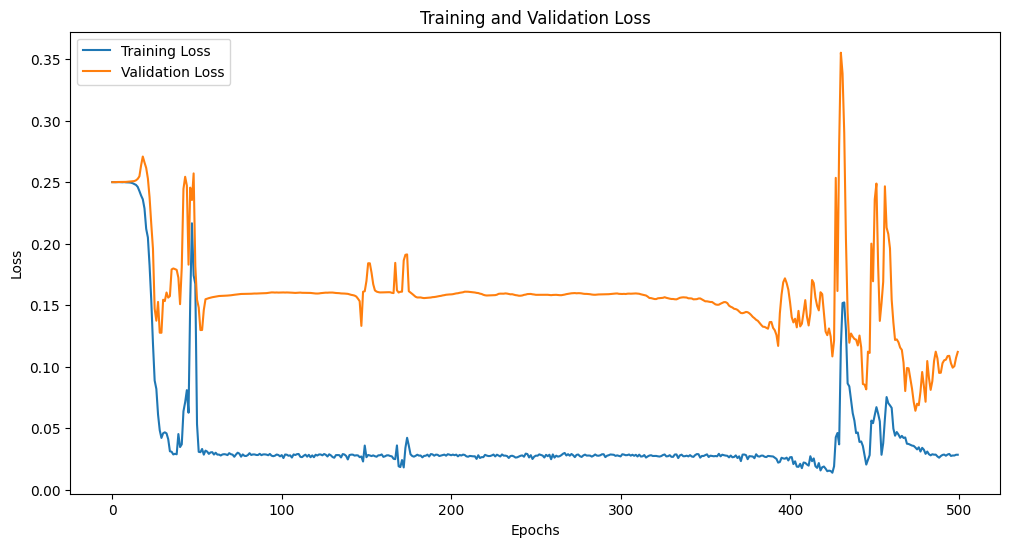

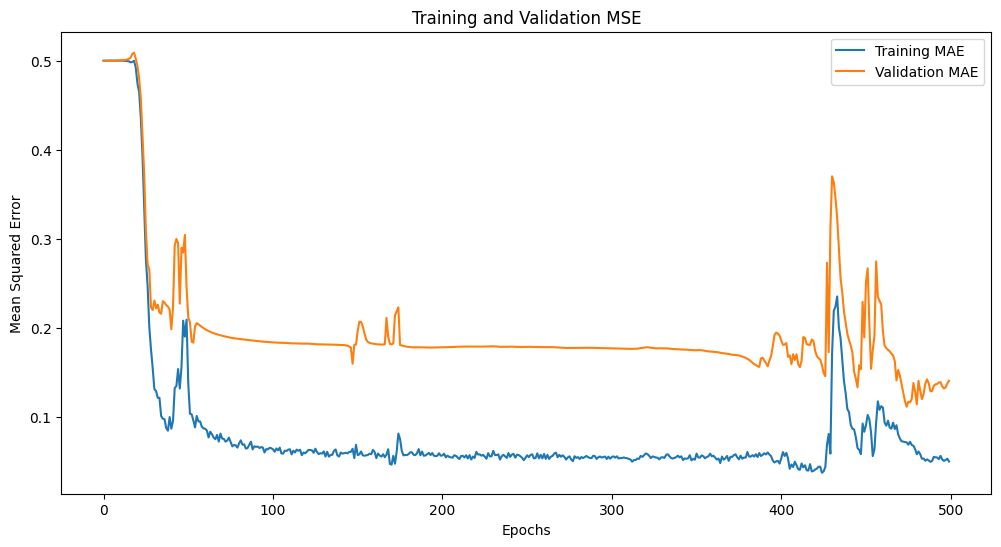

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [16]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Define threshold
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)

# Load the trained model
model = load_model("stage2-1-3.keras")

# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)


2/2 [==============================] - 1s 100ms/step
[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           1         0.999341                1
1           0         0.000410                0
2           0         0.000409                0
3           1         0.999358                1
4           1         0.999336                1
Accuracy: 0.91
Confusion Matrix:
[[22  1]
 [ 2 10]]


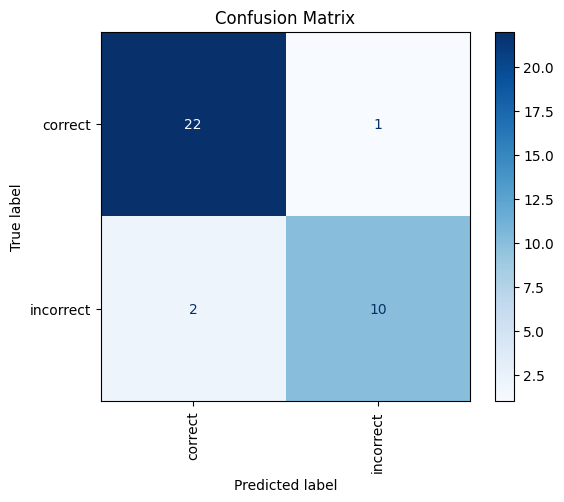

Accuracy: 0.91


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
# threshold = 0.005  # Adjust this value to experiment with different thresholds

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model with L2 regularization
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),  # Add L2 regularization
    Dropout(0.3),
    Dense(64, activation='relu'),  # Add L2 regularization to dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output: Value between 0 and 1
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
    # callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage2-1-3.keras")
print("Model training complete and saved as 'stage2-1.keras'")


Class weights: {0: 0.7692307692307693, 1: 1.4285714285714286}
Epoch 1/1000
5/5 [==============================] - 5s 578ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2499 - val_mae: 0.4999
Epoch 2/1000
5/5 [==============================] - 2s 454ms/step - loss: 0.2500 - mae: 0.4999 - val_loss: 0.2499 - val_mae: 0.4999
Epoch 3/1000
5/5 [==============================] - 2s 492ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2500 - val_mae: 0.5000
Epoch 4/1000
5/5 [==============================] - 3s 568ms/step - loss: 0.2500 - mae: 0.5001 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 5/1000
5/5 [==============================] - 3s 536ms/step - loss: 0.2500 - mae: 0.5001 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 6/1000
5/5 [==============================] - 2s 520ms/step - loss: 0.2500 - mae: 0.5001 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 7/1000
5/5 [==============================] - 3s 527ms/step - loss: 0.2499 - mae: 0.5001 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 8/1000
5

2/2 [==============================] - 1s 120ms/step
True Label: 1.000, Predicted: 0.987
True Label: 0.000, Predicted: 0.006
True Label: 0.000, Predicted: 0.006
True Label: 1.000, Predicted: 0.988
True Label: 1.000, Predicted: 0.985


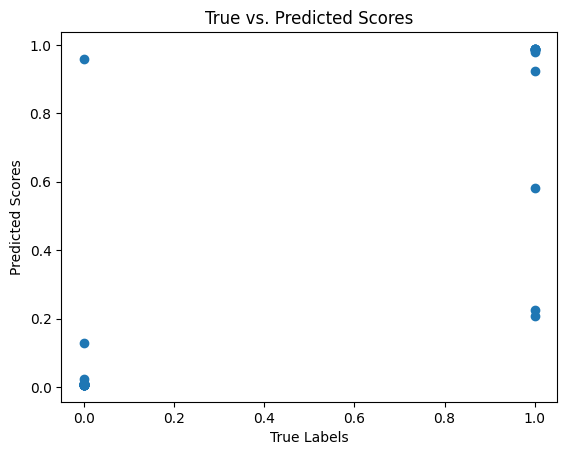

In [22]:
model = load_model("stage2.h5")
predictions = model.predict(X_val)
for i in range(5):
    print(f"True Label: {y_val[i]:.3f}, Predicted: {predictions[i][0]:.3f}")

plt.scatter(y_val, predictions)
plt.xlabel("True Labels")
plt.ylabel("Predicted Scores")
plt.title("True vs. Predicted Scores")
plt.show()
model.save('stage1_discus.keras')

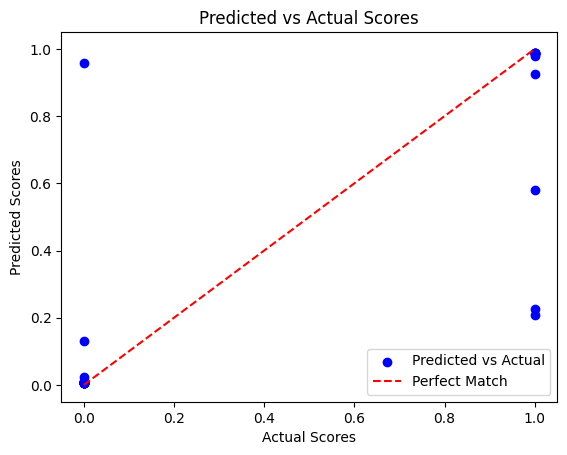

In [23]:
import matplotlib.pyplot as plt

# Scatter plot of predictions vs. actual
plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Predicted vs Actual Scores')
plt.legend()
plt.show()


# Looking at start line


In [4]:
import os
import cv2
import mediapipe as mp
import numpy as np
import math

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False)
mp_drawing = mp.solutions.drawing_utils

# Paths
videos_dir = "stage1"  # Input videos directory
output_dir = "stage2-test"  # Output directory for processed videos
os.makedirs(output_dir, exist_ok=True)


def calculate_gaze_direction(landmarks, w, h):
    """
    Calculate the direction of the gaze using the nose, eyes, and head orientation.
    """
    nose = np.array([landmarks[mp_pose.PoseLandmark.NOSE].x * w,
                     landmarks[mp_pose.PoseLandmark.NOSE].y * h])
    left_eye = np.array([landmarks[mp_pose.PoseLandmark.LEFT_EYE].x * w,
                         landmarks[mp_pose.PoseLandmark.LEFT_EYE].y * h])
    right_eye = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x * w,
                          landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y * h])
    left_shoulder = np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * w,
                              landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * h])
    right_shoulder = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * w,
                               landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * h])

    # Midpoint of the shoulders to determine head orientation
    midpoint_shoulders = (left_shoulder + right_shoulder) / 2
    head_direction_vector = (left_eye + right_eye) / 2 - nose

    # Adjust the gaze vector based on the head's orientation relative to the shoulders
    head_orientation_vector = midpoint_shoulders - nose
    adjusted_gaze_vector = head_direction_vector + 0.3 * head_orientation_vector

    # Extend the adjusted vector for visualization
    gaze_end = nose + adjusted_gaze_vector * 7  # Scale factor for visualization

    return tuple(map(int, nose)), tuple(map(int, gaze_end))


def calculate_angle(line1, line2):
    """
    Calculate the angle between two lines given as (x1, y1) -> (x2, y2).
    """
    dx1, dy1 = line1[1][0] - line1[0][0], line1[1][1] - line1[0][1]
    dx2, dy2 = line2[1][0] - line2[0][0], line2[1][1] - line2[0][1]
    dot_product = dx1 * dx2 + dy1 * dy2
    mag1 = math.sqrt(dx1**2 + dy1**2)
    mag2 = math.sqrt(dx2**2 + dy2**2)
    angle = math.acos(dot_product / (mag1 * mag2))  # Radians
    return math.degrees(angle)


def draw_lines_and_calculate_angle(frame, landmarks):
    """
    Draw lines (from legs and hands, and from the head) and calculate the angle between them.

    Args:
        frame (np.array): The video frame.
        landmarks (list): List of pose landmarks.

    Returns:
        frame: Frame with lines and angle drawn.
        angle: Angle between the two lines.
    """
    h, w, _ = frame.shape

    # Get leg coordinates (left and right toes)
    left_toe = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x * w,
                landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y * h]
    right_toe = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x * w,
                 landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y * h]

    # Midpoint of legs
    if landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].visibility > 0.5 and \
       landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].visibility > 0.5:
        midpoint_legs = [(left_toe[0] + right_toe[0]) / 2, (left_toe[1] + right_toe[1]) / 2]
    elif landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].visibility > 0.5:
        midpoint_legs = left_toe
    elif landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].visibility > 0.5:
        midpoint_legs = right_toe
    else:
        return frame, None  # Skip if no legs are detected

    # Get hand coordinates (left and right hands)
    left_hand = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x * w,
                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y * h]
    right_hand = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x * w,
                  landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y * h]

    # Midpoint of hands
    if landmarks[mp_pose.PoseLandmark.LEFT_WRIST].visibility > 0.5 and \
       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].visibility > 0.5:
        midpoint_hands = [(left_hand[0] + right_hand[0]) / 2, (left_hand[1] + right_hand[1]) / 2]
    elif landmarks[mp_pose.PoseLandmark.LEFT_WRIST].visibility > 0.5:
        midpoint_hands = left_hand
    elif landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].visibility > 0.5:
        midpoint_hands = right_hand
    else:
        return frame, None  # Skip if no hands are detected

    # Draw the extended leg-hand line
    cv2.line(frame, (int(midpoint_legs[0]), int(midpoint_legs[1])), (int(midpoint_hands[0]), int(midpoint_hands[1])), (0, 255, 0), 3)

    # Calculate gaze direction
    nose, gaze_end = calculate_gaze_direction(landmarks, w, h)

    # Draw the gaze direction line
    cv2.line(frame, nose, gaze_end, (255, 0, 0), 3)

    # Calculate the angle between the two lines
    line1 = [(int(midpoint_legs[0]), int(midpoint_legs[1])), (int(midpoint_hands[0]), int(midpoint_hands[1]))]
    line2 = [nose, gaze_end]
    angle = calculate_angle(line1, line2)

    # Display the angle
    if angle is not None:
        cv2.putText(frame, f"Angle: {angle:.2f} deg", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    return frame, angle


def process_video(video_path, output_path):
    """
    Process a video to draw lines, calculate angles, and save the processed video.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            landmarks = result.pose_landmarks.landmark
            frame, angle = draw_lines_and_calculate_angle(frame, landmarks)

        out.write(frame)  # Save the processed frame to the output video

    cap.release()
    out.release()
    print(f"Processed video saved to {output_path}")


# Process all videos in the directory
for video_file in os.listdir(videos_dir):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(videos_dir, video_file)
        video_name = os.path.splitext(video_file)[0]
        output_path = os.path.join(output_dir, f"{video_name}_processed.mp4")
        process_video(video_path, output_path)

print("Video processing completed!")


Processed video saved to stage2-test\user1_processed.mp4
Processed video saved to stage2-test\user10_processed.mp4
Processed video saved to stage2-test\user100_processed.mp4
Processed video saved to stage2-test\user101_processed.mp4
Processed video saved to stage2-test\user102_processed.mp4
Processed video saved to stage2-test\user103_processed.mp4
Processed video saved to stage2-test\user11_processed.mp4
Processed video saved to stage2-test\user12_processed.mp4
Processed video saved to stage2-test\user13_processed.mp4
Processed video saved to stage2-test\user14_processed.mp4
Processed video saved to stage2-test\user17_processed.mp4
Processed video saved to stage2-test\user19_processed.mp4
Processed video saved to stage2-test\user2_processed.mp4
Processed video saved to stage2-test\user20_processed.mp4
Processed video saved to stage2-test\user21_processed.mp4
Processed video saved to stage2-test\user22_processed.mp4
Processed video saved to stage2-test\user23_processed.mp4
Processed vi

## Keypoints extraction

In [ ]:
import os
import cv2
import mediapipe as mp
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

def calculate_gaze_direction(landmarks, w, h):
    """
    Calculate the direction of the gaze using nose and eye landmarks.
    """
    nose = [landmarks[mp_pose.PoseLandmark.NOSE].x * w, landmarks[mp_pose.PoseLandmark.NOSE].y * h]
    left_eye = [landmarks[mp_pose.PoseLandmark.LEFT_EYE].x * w, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y * h]
    right_eye = [landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y * h]

    # Calculate the midpoint of the eyes
    midpoint_eyes = [(left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2]

    # Vector from nose to the midpoint of the eyes (gaze direction vector)
    gaze_vector = np.array(midpoint_eyes) - np.array(nose)
    gaze_end = np.array(nose) + gaze_vector * 5  # Extend the vector for visualization

    return gaze_vector.tolist()

def extract_keypoints_from_frame(frame_path):
    """
    Extract keypoints and calculated features from a single frame.
    """
    image = cv2.imread(frame_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb_image)

    if result.pose_landmarks:
        h, w, _ = image.shape
        landmarks = result.pose_landmarks.landmark

        # Extract key points
        keypoints = [
            {"x": lm.x, "y": lm.y, "z": lm.z, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Select relevant keypoints
        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

        # Calculate body height (nose to midpoint of ankles)
        midpoint_ankles = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]
        body_height = calculate_distance(nose, midpoint_ankles)

        # Calculate torso length (shoulders to hips)
        midpoint_shoulders = [(left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2]
        midpoint_hips = [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2]
        torso_length = calculate_distance(midpoint_shoulders, midpoint_hips)

        # Normalize keypoints relative to body height
        normalized_keypoints = [
            {"x": lm.x / body_height, "y": lm.y / body_height, "z": lm.z / body_height, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Calculate angles
        head_torso_angle = calculate_angle(nose, midpoint_shoulders, midpoint_hips)

        # Calculate gaze direction
        gaze_vector = calculate_gaze_direction(landmarks, w, h)

        return {
            "keypoints": normalized_keypoints,
            "body_height": body_height,
            "torso_length": torso_length,
            "head_torso_angle": head_torso_angle,
            "gaze_direction": gaze_vector,
        }
    return None

def process_frames(video_frames_dir, output_path, frame_skip=3):
    """
    Process every nth frame for a video and save keypoints and features as JSON.
    
    Args:
        video_frames_dir (str): Path to the directory containing video frames.
        output_path (str): Path to save the extracted keypoints as JSON.
        frame_skip (int): Number of frames to skip between processing (default is 3).
    """
    keypoints_data = []
    frame_count = 0  # Initialize frame counter

    for frame_file in sorted(os.listdir(video_frames_dir)):
        frame_path = os.path.join(video_frames_dir, frame_file)

        # Skip frames based on frame_skip
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        keypoints = extract_keypoints_from_frame(frame_path)
        if keypoints:
            keypoints_data.append(keypoints)

        frame_count += 1  # Increment frame counter

    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Paths
frames_dir = "stage2-2-frames"
keypoints_dir = "stage2-2-dataset-json"
os.makedirs(keypoints_dir, exist_ok=True)

# Process frames for each video with frame skipping
for video_name in os.listdir(frames_dir):
    video_frames_dir = os.path.join(frames_dir, video_name)
    if os.path.isdir(video_frames_dir):
        output_path = os.path.join(keypoints_dir, f"{video_name}_keypoints.json")
        process_frames(video_frames_dir, output_path, frame_skip=3)  # Skip 2 frames, process every 3rd frame
        print(f"Keypoints extracted for {video_name}")

print("Keypoint extraction completed!")


In [8]:
import os
import cv2
import mediapipe as mp
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

def calculate_gaze_direction(landmarks, w, h):
    """
    Calculate the direction of the gaze using nose and eye landmarks.
    """
    nose = [landmarks[mp_pose.PoseLandmark.NOSE].x * w, landmarks[mp_pose.PoseLandmark.NOSE].y * h]
    left_eye = [landmarks[mp_pose.PoseLandmark.LEFT_EYE].x * w, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y * h]
    right_eye = [landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y * h]

    # Calculate the midpoint of the eyes
    midpoint_eyes = [(left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2]

    # Vector from nose to the midpoint of the eyes (gaze direction vector)
    gaze_vector = np.array(midpoint_eyes) - np.array(nose)
    gaze_end = np.array(nose) + gaze_vector * 5  # Extend the vector for visualization

    return gaze_vector.tolist()

def extract_keypoints_from_frame(frame_path):
    """
    Extract keypoints and calculated features from a single frame.
    """
    image = cv2.imread(frame_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb_image)

    if result.pose_landmarks:
        h, w, _ = image.shape
        landmarks = result.pose_landmarks.landmark

        # Extract key points
        keypoints = [
            {"x": lm.x, "y": lm.y, "z": lm.z, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Select relevant keypoints
        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]

        # Calculate body height (nose to midpoint of ankles)
        midpoint_ankles = [(left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2]
        body_height = calculate_distance(nose, midpoint_ankles)

        # Calculate torso length (shoulders to hips)
        midpoint_shoulders = [(left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2]
        midpoint_hips = [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2]
        torso_length = calculate_distance(midpoint_shoulders, midpoint_hips)

        # Normalize keypoints relative to body height
        normalized_keypoints = [
            {"x": lm.x / body_height, "y": lm.y / body_height, "z": lm.z / body_height, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Calculate angles
        head_torso_angle = calculate_angle(nose, midpoint_shoulders, midpoint_hips)

        # Calculate gaze direction
        gaze_vector = calculate_gaze_direction(landmarks, w, h)

        return {
            "keypoints": normalized_keypoints,
            "body_height": body_height,
            "torso_length": torso_length,
            "head_torso_angle": head_torso_angle,
            "gaze_direction": gaze_vector,
        }
    return None

def process_frames(video_frames_dir, output_path, frame_skip=3):
    """
    Process every nth frame for a video and save keypoints and features as JSON.
    
    Args:
        video_frames_dir (str): Path to the directory containing video frames.
        output_path (str): Path to save the extracted keypoints as JSON.
        frame_skip (int): Number of frames to skip between processing (default is 3).
    """
    keypoints_data = []
    frame_count = 0  # Initialize frame counter

    for frame_file in sorted(os.listdir(video_frames_dir)):
        frame_path = os.path.join(video_frames_dir, frame_file)

        # Skip frames based on frame_skip
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        keypoints = extract_keypoints_from_frame(frame_path)
        if keypoints:
            keypoints_data.append(keypoints)

        frame_count += 1  # Increment frame counter

    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Paths
frames_dir = "stage2-2-frames"
keypoints_dir = "stage2-2-dataset-json"
os.makedirs(keypoints_dir, exist_ok=True)

# Process frames for each video with frame skipping
for video_name in os.listdir(frames_dir):
    video_frames_dir = os.path.join(frames_dir, video_name)
    if os.path.isdir(video_frames_dir):
        output_path = os.path.join(keypoints_dir, f"{video_name}_keypoints.json")
        process_frames(video_frames_dir, output_path, frame_skip=3)  # Skip 2 frames, process every 3rd frame
        print(f"Keypoints extracted for {video_name}")

print("Keypoint extraction completed!")


Keypoints extracted for user100_brightness_frames
Keypoints extracted for user100_mirrored_frames
Keypoints extracted for user100_noise_frames
Keypoints extracted for user100_original_frames
Keypoints extracted for user100_rotate_frames
Keypoints extracted for user101_brightness_frames
Keypoints extracted for user101_mirrored_frames
Keypoints extracted for user101_noise_frames
Keypoints extracted for user101_original_frames
Keypoints extracted for user101_rotate_frames
Keypoints extracted for user102_brightness_frames
Keypoints extracted for user102_mirrored_frames
Keypoints extracted for user102_noise_frames
Keypoints extracted for user102_original_frames
Keypoints extracted for user102_rotate_frames
Keypoints extracted for user103_brightness_frames
Keypoints extracted for user103_mirrored_frames
Keypoints extracted for user103_noise_frames
Keypoints extracted for user103_original_frames
Keypoints extracted for user103_rotate_frames
Keypoints extracted for user10_brightness_frames
Key

## Model training

In [5]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Dataset Preparation
json_folder = "stage2-2-dataset-json"  # Folder containing JSON files
labels_file = "stage2-2-dataset.csv"   # CSV file with user labels
labels_df = pd.read_csv(labels_file)

# Create a mapping of users to their labels
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

X, y = [], []
max_sequence_length = 70  # Maximum sequence length for padding

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Get user ID from the filename
    if user_id not in label_mapping:
        print(f"User ID {user_id} not in label mapping. Skipping...")
        continue

    label = label_mapping[user_id]  # Get label for this user
    json_path = os.path.join(json_folder, json_file)

    with open(json_path, "r") as file:
        data = json.load(file)  # Load JSON data

    user_features = []
    for frame in data:
        try:
            # Extract body features
            body_height = frame.get("body_height", 0)
            torso_length = frame.get("torso_length", 0)
            head_torso_angle = frame.get("head_torso_angle", 0)

            # Extract keypoints (flattened x, y, z values)
            keypoints = frame.get("keypoints", [])
            if not keypoints:
                print(f"No keypoints found in frame of {json_file}. Skipping...")
                continue

            # Flatten keypoints into a single feature vector
            keypoints_flat = []
            for kp in keypoints:
                keypoints_flat.extend([kp.get("x", 0), kp.get("y", 0), kp.get("z", 0)])

            # Combine features into a single vector
            features = [body_height, torso_length, head_torso_angle] + keypoints_flat
            user_features.append(features)

        except Exception as e:
            print(f"Error processing frame in {json_file}: {e}")
            continue

    # Add user's feature sequence and label to dataset
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to ensure uniform input shape
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed sequence length
num_features = X_train.shape[2]     # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (84, 70, 102), y_train shape: (84,)
X_val shape: (36, 70, 102), y_val shape: (36,)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model with L2 regularization
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),  # Add L2 regularization
    Dropout(0.3),
    Dense(64, activation='relu'),  # Add L2 regularization to dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output: Value between 0 and 1
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
    # callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage2-2.keras")
print("Model training complete and saved as 'stage2-2.keras'")


Class weights: {0: 0.6666666666666666, 1: 2.0}
Epoch 1/500
6/6 [==============================] - 8s 814ms/step - loss: 0.2501 - mae: 0.4998 - val_loss: 0.2498 - val_mae: 0.4998
Epoch 2/500
6/6 [==============================] - 4s 716ms/step - loss: 0.2500 - mae: 0.4998 - val_loss: 0.2498 - val_mae: 0.4998
Epoch 3/500
6/6 [==============================] - 4s 733ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 4/500
6/6 [==============================] - 4s 724ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2500 - val_mae: 0.5000
Epoch 5/500
6/6 [==============================] - 4s 746ms/step - loss: 0.2500 - mae: 0.4999 - val_loss: 0.2499 - val_mae: 0.4999
Epoch 6/500
6/6 [==============================] - 4s 721ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 7/500
6/6 [==============================] - 4s 716ms/step - loss: 0.2500 - mae: 0.5001 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 8/500
6/6 [===================

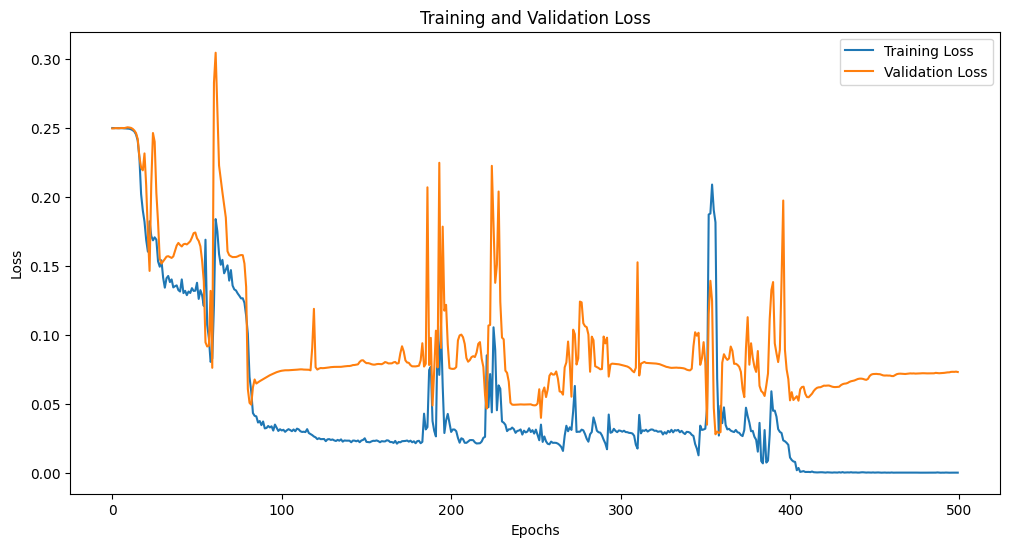

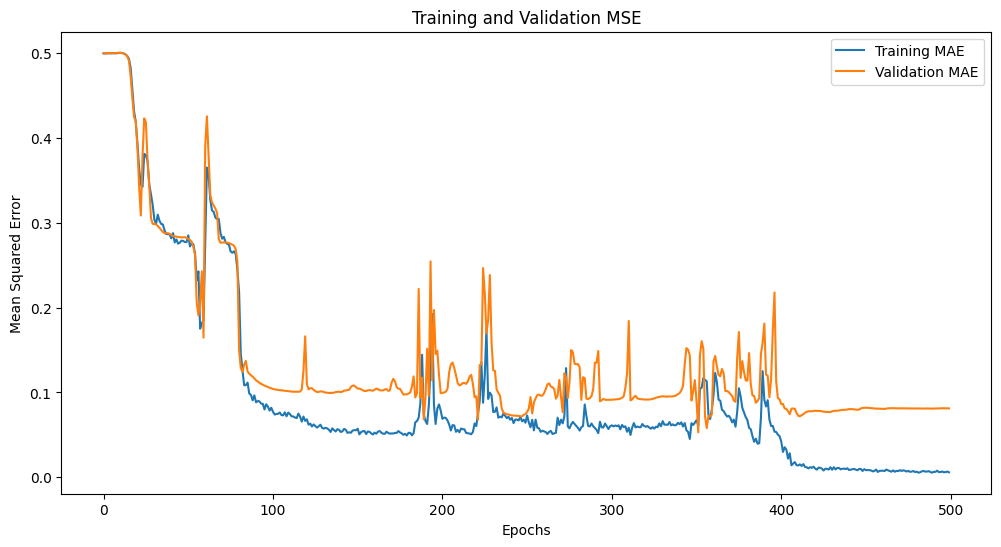

In [5]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [6]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Define threshold
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)

# Load the trained model
model = load_model("stage2-2.keras")

# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)


2/2 [==============================] - 1s 116ms/step
[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0         0.014758                0
1           0         0.002805                0
2           0         0.002649                0
3           1         0.993946                1
4           1         0.994836                1
Accuracy: 0.92
Confusion Matrix:
[[25  2]
 [ 1  8]]


2/2 [==============================] - 0s 123ms/step
[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


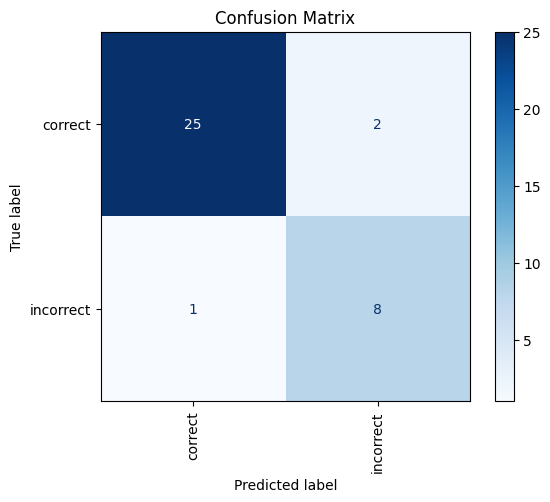

Accuracy: 0.92


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
# threshold = 0.005  # Adjust this value to experiment with different thresholds
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)


# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")
